# Generalities for GANs

* Import libraries
* Run on GPU if possible
* Create data loaders

In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from IPython.display import Image, display
import matplotlib.pyplot as plt

# create directory to save results
!mkdir results

# script parameters
batch_size = 128
log_interval = 100

# run on GPU if possible
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

# create data loaders
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Neural Network class

* Generator
* Discriminator


In [ ]:
# Generator Network
class Generator(nn.Module):

    # declare layers
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(20, 400)
        self.fc2 = nn.Linear(400, 784)

    # Forward: one ReLU hidden layer of 400 nodes, one Sigmoid output layer of 784 nodes
    def forward(self, z):

        h1 = F.relu(self.fc1(z.view(-1, 20)))
        return torch.sigmoid(self.fc2(h1))

# Discriminator Network
class Discriminator(nn.Module):

    # declare layers
    def __init__(self):
        super(Discriminator, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 1)

    # Forward: one ReLU hidden layer of 400 nodes, one Sigmoid output layer of 1 node
    def forward(self, x):

        h1 = F.relu(self.fc1(x.view(-1, 784)))
        return torch.sigmoid(self.fc2(h1))

# Loss Function

In [ ]:
# GAN Loss Function
#
# Inputs:
#    predictions: array of probabilities indicating whether the images are real or fake 
#    targets: array of 1s (real image) and 0s (fake image)
#
# Output:
#    BCE: binary cross entropy (scalar)
#
def gan_loss_function(predictions, targets):
    BCE = F.binary_cross_entropy(predictions, targets, reduction='sum')
    return BCE

# Training

In [ ]:
# GAN Training
#
# Have a look at the following tutorial: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
#
# Inputs:
#    epoch: epoch #
#    generator: generator network
#    generator_optimizer: generator optimizer
#    discriminator: discriminator network
#    discriminator_optimizer: discriminator optimizer
#
# Outputs:
#    average_generator_loss: binary cross entropy (scalar)
#    average_discriminator_loss: binary cross entropy (scalar)
#
def gan_train(epoch, generator, generator_optimizer, discriminator, discriminator_optimizer):

    average_discriminator_loss = 0
    average_generator_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        #print("DATA SIZE: ",end='')
        #print(data.size())
        discriminator_optimizer.zero_grad()
        output=discriminator(data)
        label = torch.full(output.size(), 1, dtype=torch.float, device=device)
        errD_real = gan_loss_function(output,label)
        errD_real.backward()
        D_x = output.mean().item()
        
        noise = torch.randn(len(data), 20).to(device)
        fake = generator(noise)
        output = discriminator(fake.detach())
        label = torch.full(output.size(), 0, dtype=torch.float, device=device)
        errD_fake = gan_loss_function(output,label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        discriminator_optimizer.step()

        generator.zero_grad()
        label.fill_(1)
        output = discriminator(fake)
        errG = gan_loss_function(output,label)
        errG.backward()
        D_G_z2 = output.mean().item()
        generator_optimizer.step()

        if batch_idx % log_interval == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tDiscriminator Loss: {:.6f}\tGenerator Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                errD.item() / len(data),
                errG.item() / len(data)))
        average_generator_loss += errG.item()
        average_discriminator_loss +=errD.item()
    average_generator_loss = average_generator_loss / len(train_loader.dataset)
    average_discriminator_loss = average_discriminator_loss / len(train_loader.dataset)
    print('====> Epoch: {} Average Train Generator loss: {:.4f}'.format(
            epoch, average_generator_loss))
    print('====> Epoch: {} Average Train Discriminator loss: {:.4f}'.format(
            epoch, average_discriminator_loss))
    return average_generator_loss, average_discriminator_loss


# Testing


In [ ]:
# GAN Test
#
# Have a look at the following tutorial: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
#
# Inputs:
#    epoch: epoch #
#    generator: generator network
#    discriminator: discriminator network
#
# Outputs:
#    average_generator_loss: binary cross entropy (scalar)
#    average_discriminator_loss: binary cross entropy (scalar)
#
def gan_test(epoch, generator, discriminator):
    generator.eval()
    discriminator.eval()
    average_generator_loss = 0
    average_discriminator_loss = 0
    with torch.no_grad():
      for i, (data, _) in enumerate(test_loader):
        data=data.to(device)
        output=discriminator(data)
        label = torch.full(output.size(), 1, dtype=torch.float, device=device)
        errD_real = gan_loss_function(output,label)

        noise = torch.randn(len(data), 20).to(device)
        fake = generator(noise)
        output = discriminator(fake.detach())
        label = torch.full(output.size(), 0, dtype=torch.float, device=device)
        errD_fake = gan_loss_function(output,label)

        errD = errD_real + errD_fake

        label.fill_(1)
        output = discriminator(fake.detach())
        errG = gan_loss_function(output,label)
        average_generator_loss +=errG.item()
        average_discriminator_loss+=errD.item()
      average_generator_loss = average_generator_loss / len(test_loader.dataset)
      average_discriminator_loss = average_discriminator_loss / len(test_loader.dataset)
      print('====> Epoch: {} Average Test Generator loss: {:.4f}'.format(
            epoch, average_generator_loss))
      print('====> Epoch: {} Average Test Discriminator loss: {:.4f}'.format(
            epoch, average_discriminator_loss))
    return average_generator_loss, average_discriminator_loss


# Main

Train Epoch: 1 [0/60000 (0%)]	Discriminator Loss: 1.396025	Generator Loss: 1.698986
Train Epoch: 1 [12800/60000 (21%)]	Discriminator Loss: 0.154027	Generator Loss: 4.438221
Train Epoch: 1 [25600/60000 (43%)]	Discriminator Loss: 0.009340	Generator Loss: 6.299277
Train Epoch: 1 [38400/60000 (64%)]	Discriminator Loss: 0.071093	Generator Loss: 6.209255
Train Epoch: 1 [51200/60000 (85%)]	Discriminator Loss: 0.002921	Generator Loss: 7.314563
====> Epoch: 1 Average Train Generator loss: 5.6548
====> Epoch: 1 Average Train Discriminator loss: 0.1240
====> Epoch: 1 Average Test Generator loss: 6.0277
====> Epoch: 1 Average Test Discriminator loss: 0.0163
Sample of generated images


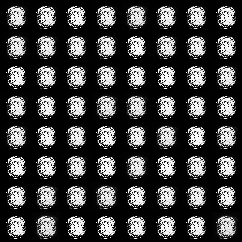



Train Epoch: 2 [0/60000 (0%)]	Discriminator Loss: 0.010948	Generator Loss: 7.135655
Train Epoch: 2 [12800/60000 (21%)]	Discriminator Loss: 0.005508	Generator Loss: 8.862876
Train Epoch: 2 [25600/60000 (43%)]	Discriminator Loss: 0.003869	Generator Loss: 7.767842
Train Epoch: 2 [38400/60000 (64%)]	Discriminator Loss: 0.033077	Generator Loss: 7.040452
Train Epoch: 2 [51200/60000 (85%)]	Discriminator Loss: 0.004091	Generator Loss: 8.962494
====> Epoch: 2 Average Train Generator loss: 7.5674
====> Epoch: 2 Average Train Discriminator loss: 0.0190
====> Epoch: 2 Average Test Generator loss: 7.3581
====> Epoch: 2 Average Test Discriminator loss: 0.0139
Sample of generated images


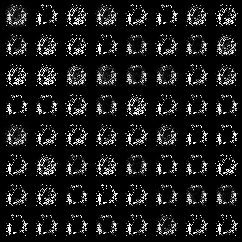



Train Epoch: 3 [0/60000 (0%)]	Discriminator Loss: 0.016283	Generator Loss: 8.061530


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 3 [12800/60000 (21%)]	Discriminator Loss: 0.008624	Generator Loss: 6.727744
Train Epoch: 3 [25600/60000 (43%)]	Discriminator Loss: 0.009990	Generator Loss: 7.098566
Train Epoch: 3 [38400/60000 (64%)]	Discriminator Loss: 0.004218	Generator Loss: 7.355001
Train Epoch: 3 [51200/60000 (85%)]	Discriminator Loss: 0.006835	Generator Loss: 8.162814
====> Epoch: 3 Average Train Generator loss: 7.3860
====> Epoch: 3 Average Train Discriminator loss: 0.0149


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


====> Epoch: 3 Average Test Generator loss: 7.7830
====> Epoch: 3 Average Test Discriminator loss: 0.0038
Sample of generated images


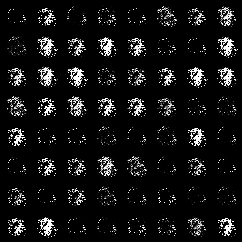



Train Epoch: 4 [0/60000 (0%)]	Discriminator Loss: 0.002172	Generator Loss: 8.685417


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 4 [12800/60000 (21%)]	Discriminator Loss: 0.018674	Generator Loss: 8.450299
Train Epoch: 4 [25600/60000 (43%)]	Discriminator Loss: 0.004657	Generator Loss: 7.195375
Train Epoch: 4 [38400/60000 (64%)]	Discriminator Loss: 0.008668	Generator Loss: 7.474822
Train Epoch: 4 [51200/60000 (85%)]	Discriminator Loss: 0.018911	Generator Loss: 6.410241
====> Epoch: 4 Average Train Generator loss: 7.2665
====> Epoch: 4 Average Train Discriminator loss: 0.0161
====> Epoch: 4 Average Test Generator loss: 6.8999
====> Epoch: 4 Average Test Discriminator loss: 0.0192
Sample of generated images


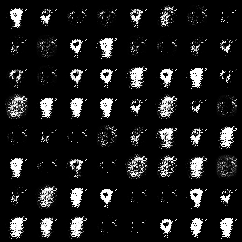



Train Epoch: 5 [0/60000 (0%)]	Discriminator Loss: 0.029505	Generator Loss: 7.169423


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 5 [12800/60000 (21%)]	Discriminator Loss: 0.027060	Generator Loss: 7.633539
Train Epoch: 5 [25600/60000 (43%)]	Discriminator Loss: 0.024060	Generator Loss: 7.379655
Train Epoch: 5 [38400/60000 (64%)]	Discriminator Loss: 0.037963	Generator Loss: 6.063569
Train Epoch: 5 [51200/60000 (85%)]	Discriminator Loss: 0.006427	Generator Loss: 7.560349
====> Epoch: 5 Average Train Generator loss: 7.6052
====> Epoch: 5 Average Train Discriminator loss: 0.0178
====> Epoch: 5 Average Test Generator loss: 7.5219
====> Epoch: 5 Average Test Discriminator loss: 0.0085
Sample of generated images


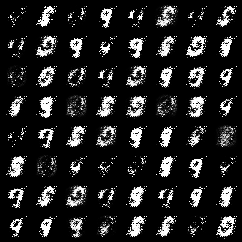



Train Epoch: 6 [0/60000 (0%)]	Discriminator Loss: 0.018962	Generator Loss: 8.204018


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 6 [12800/60000 (21%)]	Discriminator Loss: 0.020155	Generator Loss: 9.514191
Train Epoch: 6 [25600/60000 (43%)]	Discriminator Loss: 0.009957	Generator Loss: 8.231915
Train Epoch: 6 [38400/60000 (64%)]	Discriminator Loss: 0.017220	Generator Loss: 7.360265
Train Epoch: 6 [51200/60000 (85%)]	Discriminator Loss: 0.058500	Generator Loss: 7.539138
====> Epoch: 6 Average Train Generator loss: 8.0369
====> Epoch: 6 Average Train Discriminator loss: 0.0201


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


====> Epoch: 6 Average Test Generator loss: 6.6246
====> Epoch: 6 Average Test Discriminator loss: 0.0174
Sample of generated images


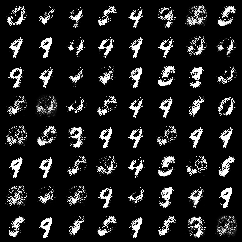



Train Epoch: 7 [0/60000 (0%)]	Discriminator Loss: 0.010672	Generator Loss: 7.299933


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 7 [12800/60000 (21%)]	Discriminator Loss: 0.019296	Generator Loss: 8.019762
Train Epoch: 7 [25600/60000 (43%)]	Discriminator Loss: 0.021011	Generator Loss: 6.837818
Train Epoch: 7 [38400/60000 (64%)]	Discriminator Loss: 0.023824	Generator Loss: 7.600070
Train Epoch: 7 [51200/60000 (85%)]	Discriminator Loss: 0.013285	Generator Loss: 7.725736
====> Epoch: 7 Average Train Generator loss: 7.6287
====> Epoch: 7 Average Train Discriminator loss: 0.0255


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


====> Epoch: 7 Average Test Generator loss: 7.1863
====> Epoch: 7 Average Test Discriminator loss: 0.0225
Sample of generated images


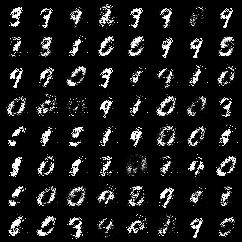



Train Epoch: 8 [0/60000 (0%)]	Discriminator Loss: 0.009172	Generator Loss: 8.238464


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 8 [12800/60000 (21%)]	Discriminator Loss: 0.038153	Generator Loss: 8.418741
Train Epoch: 8 [25600/60000 (43%)]	Discriminator Loss: 0.018321	Generator Loss: 7.435323
Train Epoch: 8 [38400/60000 (64%)]	Discriminator Loss: 0.036679	Generator Loss: 7.861358
Train Epoch: 8 [51200/60000 (85%)]	Discriminator Loss: 0.019673	Generator Loss: 6.809115
====> Epoch: 8 Average Train Generator loss: 7.5907
====> Epoch: 8 Average Train Discriminator loss: 0.0311


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


====> Epoch: 8 Average Test Generator loss: 7.8214
====> Epoch: 8 Average Test Discriminator loss: 0.0738
Sample of generated images


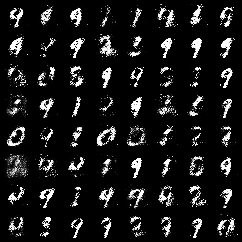



Train Epoch: 9 [0/60000 (0%)]	Discriminator Loss: 0.026830	Generator Loss: 8.117323


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 9 [12800/60000 (21%)]	Discriminator Loss: 0.057667	Generator Loss: 7.316354
Train Epoch: 9 [25600/60000 (43%)]	Discriminator Loss: 0.050502	Generator Loss: 6.478873
Train Epoch: 9 [38400/60000 (64%)]	Discriminator Loss: 0.042411	Generator Loss: 6.144515
Train Epoch: 9 [51200/60000 (85%)]	Discriminator Loss: 0.055221	Generator Loss: 6.988858
====> Epoch: 9 Average Train Generator loss: 6.9768
====> Epoch: 9 Average Train Discriminator loss: 0.0580


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


====> Epoch: 9 Average Test Generator loss: 6.7150
====> Epoch: 9 Average Test Discriminator loss: 0.0644
Sample of generated images


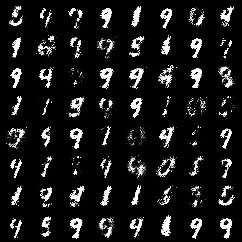



Train Epoch: 10 [0/60000 (0%)]	Discriminator Loss: 0.065328	Generator Loss: 7.439347


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 10 [12800/60000 (21%)]	Discriminator Loss: 0.102925	Generator Loss: 7.759799
Train Epoch: 10 [25600/60000 (43%)]	Discriminator Loss: 0.081809	Generator Loss: 6.950488
Train Epoch: 10 [38400/60000 (64%)]	Discriminator Loss: 0.062698	Generator Loss: 7.554199
Train Epoch: 10 [51200/60000 (85%)]	Discriminator Loss: 0.079487	Generator Loss: 7.814406
====> Epoch: 10 Average Train Generator loss: 7.1661
====> Epoch: 10 Average Train Discriminator loss: 0.0971


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


====> Epoch: 10 Average Test Generator loss: 6.5208
====> Epoch: 10 Average Test Discriminator loss: 0.1035
Sample of generated images


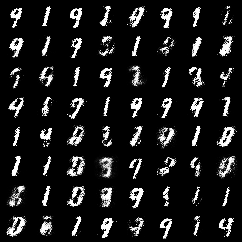

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 11 [0/60000 (0%)]	Discriminator Loss: 0.064440	Generator Loss: 7.531107
Train Epoch: 11 [12800/60000 (21%)]	Discriminator Loss: 0.144018	Generator Loss: 7.609244
Train Epoch: 11 [25600/60000 (43%)]	Discriminator Loss: 0.196637	Generator Loss: 5.567032
Train Epoch: 11 [38400/60000 (64%)]	Discriminator Loss: 0.184676	Generator Loss: 5.756155
Train Epoch: 11 [51200/60000 (85%)]	Discriminator Loss: 0.115227	Generator Loss: 6.304345
====> Epoch: 11 Average Train Generator loss: 6.1272
====> Epoch: 11 Average Train Discriminator loss: 0.1515


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


====> Epoch: 11 Average Test Generator loss: 4.6788
====> Epoch: 11 Average Test Discriminator loss: 0.1784
Sample of generated images


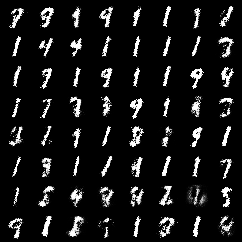



Train Epoch: 12 [0/60000 (0%)]	Discriminator Loss: 0.166582	Generator Loss: 5.448675


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 12 [12800/60000 (21%)]	Discriminator Loss: 0.244536	Generator Loss: 4.920952
Train Epoch: 12 [25600/60000 (43%)]	Discriminator Loss: 0.196332	Generator Loss: 5.447289
Train Epoch: 12 [38400/60000 (64%)]	Discriminator Loss: 0.156072	Generator Loss: 5.283157
Train Epoch: 12 [51200/60000 (85%)]	Discriminator Loss: 0.208152	Generator Loss: 4.440686
====> Epoch: 12 Average Train Generator loss: 5.0975
====> Epoch: 12 Average Train Discriminator loss: 0.1871


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


====> Epoch: 12 Average Test Generator loss: 3.9557
====> Epoch: 12 Average Test Discriminator loss: 0.2136
Sample of generated images


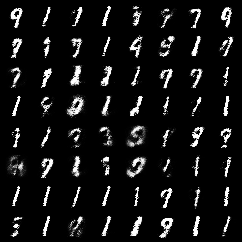

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 13 [0/60000 (0%)]	Discriminator Loss: 0.236827	Generator Loss: 4.593915
Train Epoch: 13 [12800/60000 (21%)]	Discriminator Loss: 0.201854	Generator Loss: 4.617223
Train Epoch: 13 [25600/60000 (43%)]	Discriminator Loss: 0.231908	Generator Loss: 4.136082
Train Epoch: 13 [38400/60000 (64%)]	Discriminator Loss: 0.249663	Generator Loss: 4.050005
Train Epoch: 13 [51200/60000 (85%)]	Discriminator Loss: 0.262343	Generator Loss: 4.060902
====> Epoch: 13 Average Train Generator loss: 4.6167
====> Epoch: 13 Average Train Discriminator loss: 0.2247


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


====> Epoch: 13 Average Test Generator loss: 3.9963
====> Epoch: 13 Average Test Discriminator loss: 0.2087
Sample of generated images


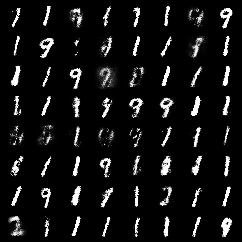



Train Epoch: 14 [0/60000 (0%)]	Discriminator Loss: 0.161651	Generator Loss: 4.760012


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 14 [12800/60000 (21%)]	Discriminator Loss: 0.238204	Generator Loss: 5.478777
Train Epoch: 14 [25600/60000 (43%)]	Discriminator Loss: 0.373780	Generator Loss: 4.332613
Train Epoch: 14 [38400/60000 (64%)]	Discriminator Loss: 0.244094	Generator Loss: 4.102110
Train Epoch: 14 [51200/60000 (85%)]	Discriminator Loss: 0.370327	Generator Loss: 3.580074
====> Epoch: 14 Average Train Generator loss: 4.4835
====> Epoch: 14 Average Train Discriminator loss: 0.2634


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


====> Epoch: 14 Average Test Generator loss: 3.6019
====> Epoch: 14 Average Test Discriminator loss: 0.3038
Sample of generated images


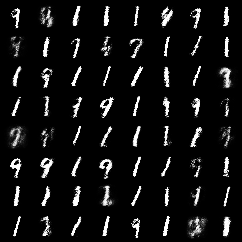



Train Epoch: 15 [0/60000 (0%)]	Discriminator Loss: 0.254025	Generator Loss: 3.856782


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 15 [12800/60000 (21%)]	Discriminator Loss: 0.285154	Generator Loss: 4.252688
Train Epoch: 15 [25600/60000 (43%)]	Discriminator Loss: 0.261417	Generator Loss: 3.824419
Train Epoch: 15 [38400/60000 (64%)]	Discriminator Loss: 0.158765	Generator Loss: 4.885396
Train Epoch: 15 [51200/60000 (85%)]	Discriminator Loss: 0.435754	Generator Loss: 4.015306
====> Epoch: 15 Average Train Generator loss: 4.1639
====> Epoch: 15 Average Train Discriminator loss: 0.3032


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


====> Epoch: 15 Average Test Generator loss: 4.3370
====> Epoch: 15 Average Test Discriminator loss: 0.2801
Sample of generated images


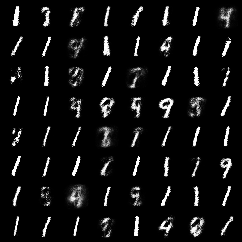



Train Epoch: 16 [0/60000 (0%)]	Discriminator Loss: 0.310804	Generator Loss: 4.702682


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 16 [12800/60000 (21%)]	Discriminator Loss: 0.128882	Generator Loss: 4.418690
Train Epoch: 16 [25600/60000 (43%)]	Discriminator Loss: 0.244903	Generator Loss: 4.449146
Train Epoch: 16 [38400/60000 (64%)]	Discriminator Loss: 0.220694	Generator Loss: 3.968369
Train Epoch: 16 [51200/60000 (85%)]	Discriminator Loss: 0.458831	Generator Loss: 3.162152
====> Epoch: 16 Average Train Generator loss: 3.9534
====> Epoch: 16 Average Train Discriminator loss: 0.3225


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


====> Epoch: 16 Average Test Generator loss: 3.1123
====> Epoch: 16 Average Test Discriminator loss: 0.3545
Sample of generated images


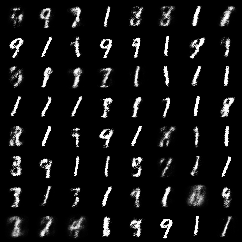



Train Epoch: 17 [0/60000 (0%)]	Discriminator Loss: 0.314112	Generator Loss: 3.743991


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 17 [12800/60000 (21%)]	Discriminator Loss: 0.318706	Generator Loss: 3.698750
Train Epoch: 17 [25600/60000 (43%)]	Discriminator Loss: 0.225064	Generator Loss: 4.234086
Train Epoch: 17 [38400/60000 (64%)]	Discriminator Loss: 0.270211	Generator Loss: 3.031919
Train Epoch: 17 [51200/60000 (85%)]	Discriminator Loss: 0.360548	Generator Loss: 3.507387
====> Epoch: 17 Average Train Generator loss: 3.7796
====> Epoch: 17 Average Train Discriminator loss: 0.3397


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


====> Epoch: 17 Average Test Generator loss: 3.4395
====> Epoch: 17 Average Test Discriminator loss: 0.4438
Sample of generated images


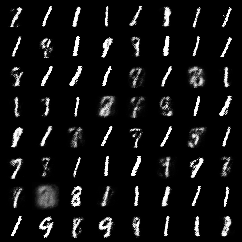

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 18 [0/60000 (0%)]	Discriminator Loss: 0.375240	Generator Loss: 3.981114
Train Epoch: 18 [12800/60000 (21%)]	Discriminator Loss: 0.251910	Generator Loss: 3.995500
Train Epoch: 18 [25600/60000 (43%)]	Discriminator Loss: 0.266060	Generator Loss: 4.157746
Train Epoch: 18 [38400/60000 (64%)]	Discriminator Loss: 0.260657	Generator Loss: 4.294073
Train Epoch: 18 [51200/60000 (85%)]	Discriminator Loss: 0.333406	Generator Loss: 3.394365
====> Epoch: 18 Average Train Generator loss: 3.8201
====> Epoch: 18 Average Train Discriminator loss: 0.3447


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


====> Epoch: 18 Average Test Generator loss: 3.8622
====> Epoch: 18 Average Test Discriminator loss: 0.3197
Sample of generated images


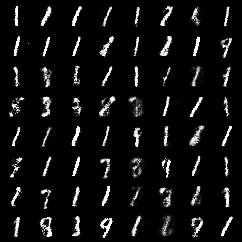



Train Epoch: 19 [0/60000 (0%)]	Discriminator Loss: 0.207945	Generator Loss: 3.803998


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 19 [12800/60000 (21%)]	Discriminator Loss: 0.248839	Generator Loss: 4.182588
Train Epoch: 19 [25600/60000 (43%)]	Discriminator Loss: 0.309456	Generator Loss: 3.546090
Train Epoch: 19 [38400/60000 (64%)]	Discriminator Loss: 0.348936	Generator Loss: 3.260870
Train Epoch: 19 [51200/60000 (85%)]	Discriminator Loss: 0.283475	Generator Loss: 4.387836
====> Epoch: 19 Average Train Generator loss: 3.6551
====> Epoch: 19 Average Train Discriminator loss: 0.3712


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


====> Epoch: 19 Average Test Generator loss: 2.8919
====> Epoch: 19 Average Test Discriminator loss: 0.4035
Sample of generated images


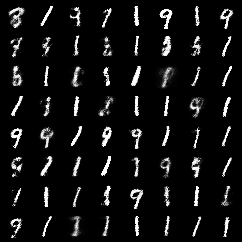

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 20 [0/60000 (0%)]	Discriminator Loss: 0.259200	Generator Loss: 3.498093
Train Epoch: 20 [12800/60000 (21%)]	Discriminator Loss: 0.207326	Generator Loss: 3.539549
Train Epoch: 20 [25600/60000 (43%)]	Discriminator Loss: 0.470418	Generator Loss: 2.464225
Train Epoch: 20 [38400/60000 (64%)]	Discriminator Loss: 0.316063	Generator Loss: 3.699815
Train Epoch: 20 [51200/60000 (85%)]	Discriminator Loss: 0.483115	Generator Loss: 2.947594
====> Epoch: 20 Average Train Generator loss: 3.5240
====> Epoch: 20 Average Train Discriminator loss: 0.3821


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


====> Epoch: 20 Average Test Generator loss: 3.0093
====> Epoch: 20 Average Test Discriminator loss: 0.4441
Sample of generated images


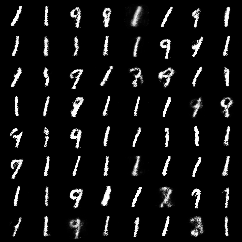



Train Epoch: 21 [0/60000 (0%)]	Discriminator Loss: 0.391545	Generator Loss: 3.359467


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 21 [12800/60000 (21%)]	Discriminator Loss: 0.447869	Generator Loss: 3.812560
Train Epoch: 21 [25600/60000 (43%)]	Discriminator Loss: 0.473132	Generator Loss: 3.360004
Train Epoch: 21 [38400/60000 (64%)]	Discriminator Loss: 0.316017	Generator Loss: 4.205764
Train Epoch: 21 [51200/60000 (85%)]	Discriminator Loss: 0.307786	Generator Loss: 4.055249
====> Epoch: 21 Average Train Generator loss: 3.5678
====> Epoch: 21 Average Train Discriminator loss: 0.3945


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


====> Epoch: 21 Average Test Generator loss: 3.5231
====> Epoch: 21 Average Test Discriminator loss: 0.4308
Sample of generated images


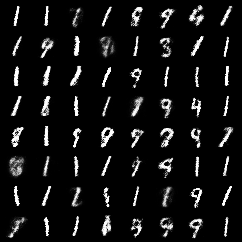



Train Epoch: 22 [0/60000 (0%)]	Discriminator Loss: 0.448014	Generator Loss: 3.968032


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 22 [12800/60000 (21%)]	Discriminator Loss: 0.553652	Generator Loss: 3.273248
Train Epoch: 22 [25600/60000 (43%)]	Discriminator Loss: 0.600155	Generator Loss: 3.671178
Train Epoch: 22 [38400/60000 (64%)]	Discriminator Loss: 0.350156	Generator Loss: 3.580473
Train Epoch: 22 [51200/60000 (85%)]	Discriminator Loss: 0.496781	Generator Loss: 3.314370
====> Epoch: 22 Average Train Generator loss: 3.5085
====> Epoch: 22 Average Train Discriminator loss: 0.4051


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


====> Epoch: 22 Average Test Generator loss: 3.4065
====> Epoch: 22 Average Test Discriminator loss: 0.4918
Sample of generated images


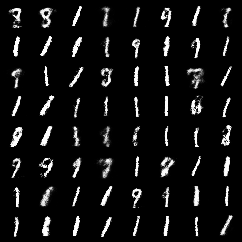



Train Epoch: 23 [0/60000 (0%)]	Discriminator Loss: 0.322181	Generator Loss: 3.558382


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 23 [12800/60000 (21%)]	Discriminator Loss: 0.391234	Generator Loss: 2.868746
Train Epoch: 23 [25600/60000 (43%)]	Discriminator Loss: 0.427085	Generator Loss: 3.454666
Train Epoch: 23 [38400/60000 (64%)]	Discriminator Loss: 0.327359	Generator Loss: 3.692956
Train Epoch: 23 [51200/60000 (85%)]	Discriminator Loss: 0.370930	Generator Loss: 3.409277
====> Epoch: 23 Average Train Generator loss: 3.3375
====> Epoch: 23 Average Train Discriminator loss: 0.4166


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


====> Epoch: 23 Average Test Generator loss: 2.8391
====> Epoch: 23 Average Test Discriminator loss: 0.4382
Sample of generated images


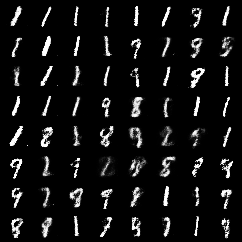



Train Epoch: 24 [0/60000 (0%)]	Discriminator Loss: 0.504534	Generator Loss: 2.862687


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 24 [12800/60000 (21%)]	Discriminator Loss: 0.312129	Generator Loss: 3.424045
Train Epoch: 24 [25600/60000 (43%)]	Discriminator Loss: 0.468742	Generator Loss: 3.698277
Train Epoch: 24 [38400/60000 (64%)]	Discriminator Loss: 0.299363	Generator Loss: 3.458394
Train Epoch: 24 [51200/60000 (85%)]	Discriminator Loss: 0.624309	Generator Loss: 3.582446
====> Epoch: 24 Average Train Generator loss: 3.2646
====> Epoch: 24 Average Train Discriminator loss: 0.4221


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


====> Epoch: 24 Average Test Generator loss: 3.6604
====> Epoch: 24 Average Test Discriminator loss: 0.4952
Sample of generated images


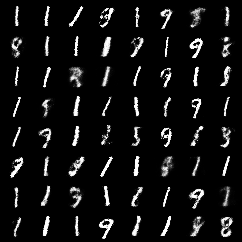

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 25 [0/60000 (0%)]	Discriminator Loss: 0.480874	Generator Loss: 3.794241
Train Epoch: 25 [12800/60000 (21%)]	Discriminator Loss: 0.394170	Generator Loss: 3.061062
Train Epoch: 25 [25600/60000 (43%)]	Discriminator Loss: 0.416504	Generator Loss: 2.760906
Train Epoch: 25 [38400/60000 (64%)]	Discriminator Loss: 0.615925	Generator Loss: 2.606846
Train Epoch: 25 [51200/60000 (85%)]	Discriminator Loss: 0.452403	Generator Loss: 2.954431
====> Epoch: 25 Average Train Generator loss: 3.2710
====> Epoch: 25 Average Train Discriminator loss: 0.4278


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


====> Epoch: 25 Average Test Generator loss: 2.9168
====> Epoch: 25 Average Test Discriminator loss: 0.5493
Sample of generated images


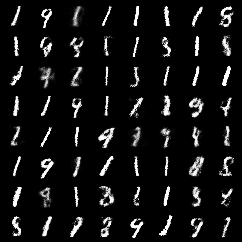



Train Epoch: 26 [0/60000 (0%)]	Discriminator Loss: 0.475737	Generator Loss: 3.019094


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 26 [12800/60000 (21%)]	Discriminator Loss: 0.505154	Generator Loss: 3.303394
Train Epoch: 26 [25600/60000 (43%)]	Discriminator Loss: 0.357845	Generator Loss: 3.429002
Train Epoch: 26 [38400/60000 (64%)]	Discriminator Loss: 0.502431	Generator Loss: 2.648459
Train Epoch: 26 [51200/60000 (85%)]	Discriminator Loss: 0.507661	Generator Loss: 3.025595
====> Epoch: 26 Average Train Generator loss: 3.2748
====> Epoch: 26 Average Train Discriminator loss: 0.4381


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


====> Epoch: 26 Average Test Generator loss: 3.0687
====> Epoch: 26 Average Test Discriminator loss: 0.4942
Sample of generated images


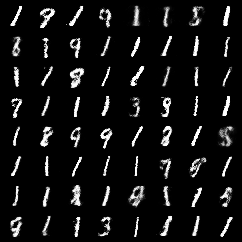

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 27 [0/60000 (0%)]	Discriminator Loss: 0.383330	Generator Loss: 3.294145
Train Epoch: 27 [12800/60000 (21%)]	Discriminator Loss: 0.377415	Generator Loss: 3.405830
Train Epoch: 27 [25600/60000 (43%)]	Discriminator Loss: 0.475456	Generator Loss: 3.443651
Train Epoch: 27 [38400/60000 (64%)]	Discriminator Loss: 0.475380	Generator Loss: 3.124931
Train Epoch: 27 [51200/60000 (85%)]	Discriminator Loss: 0.404040	Generator Loss: 3.546497
====> Epoch: 27 Average Train Generator loss: 3.2675
====> Epoch: 27 Average Train Discriminator loss: 0.4360


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


====> Epoch: 27 Average Test Generator loss: 2.7641
====> Epoch: 27 Average Test Discriminator loss: 0.4531
Sample of generated images


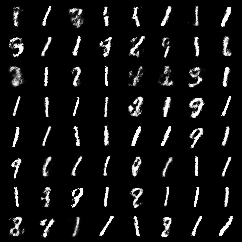



Train Epoch: 28 [0/60000 (0%)]	Discriminator Loss: 0.497261	Generator Loss: 3.041312


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 28 [12800/60000 (21%)]	Discriminator Loss: 0.403959	Generator Loss: 3.230177
Train Epoch: 28 [25600/60000 (43%)]	Discriminator Loss: 0.398898	Generator Loss: 3.075131
Train Epoch: 28 [38400/60000 (64%)]	Discriminator Loss: 0.408906	Generator Loss: 3.346245
Train Epoch: 28 [51200/60000 (85%)]	Discriminator Loss: 0.339883	Generator Loss: 3.584101
====> Epoch: 28 Average Train Generator loss: 3.1927
====> Epoch: 28 Average Train Discriminator loss: 0.4491


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


====> Epoch: 28 Average Test Generator loss: 2.7700
====> Epoch: 28 Average Test Discriminator loss: 0.4619
Sample of generated images


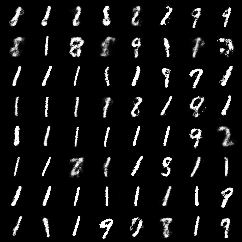

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 29 [0/60000 (0%)]	Discriminator Loss: 0.442999	Generator Loss: 3.135717
Train Epoch: 29 [12800/60000 (21%)]	Discriminator Loss: 0.291848	Generator Loss: 3.815951
Train Epoch: 29 [25600/60000 (43%)]	Discriminator Loss: 0.388661	Generator Loss: 2.997097
Train Epoch: 29 [38400/60000 (64%)]	Discriminator Loss: 0.591381	Generator Loss: 2.352390
Train Epoch: 29 [51200/60000 (85%)]	Discriminator Loss: 0.428480	Generator Loss: 2.934154
====> Epoch: 29 Average Train Generator loss: 3.0984
====> Epoch: 29 Average Train Discriminator loss: 0.4575


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


====> Epoch: 29 Average Test Generator loss: 2.6449
====> Epoch: 29 Average Test Discriminator loss: 0.5734
Sample of generated images


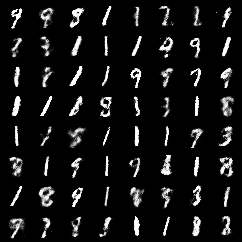



Train Epoch: 30 [0/60000 (0%)]	Discriminator Loss: 0.510141	Generator Loss: 2.830700


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 30 [12800/60000 (21%)]	Discriminator Loss: 0.387638	Generator Loss: 3.128143
Train Epoch: 30 [25600/60000 (43%)]	Discriminator Loss: 0.282274	Generator Loss: 3.387062
Train Epoch: 30 [38400/60000 (64%)]	Discriminator Loss: 0.481071	Generator Loss: 3.110440
Train Epoch: 30 [51200/60000 (85%)]	Discriminator Loss: 0.435902	Generator Loss: 2.929714
====> Epoch: 30 Average Train Generator loss: 2.9956
====> Epoch: 30 Average Train Discriminator loss: 0.4598


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


====> Epoch: 30 Average Test Generator loss: 3.0680
====> Epoch: 30 Average Test Discriminator loss: 0.5680
Sample of generated images


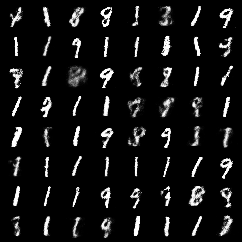



Train Epoch: 31 [0/60000 (0%)]	Discriminator Loss: 0.530902	Generator Loss: 3.089789


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 31 [12800/60000 (21%)]	Discriminator Loss: 0.473485	Generator Loss: 3.027466
Train Epoch: 31 [25600/60000 (43%)]	Discriminator Loss: 0.423314	Generator Loss: 3.205705
Train Epoch: 31 [38400/60000 (64%)]	Discriminator Loss: 0.275527	Generator Loss: 3.224654
Train Epoch: 31 [51200/60000 (85%)]	Discriminator Loss: 0.452888	Generator Loss: 3.487864
====> Epoch: 31 Average Train Generator loss: 3.0229
====> Epoch: 31 Average Train Discriminator loss: 0.4694


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


====> Epoch: 31 Average Test Generator loss: 2.8826
====> Epoch: 31 Average Test Discriminator loss: 0.5186
Sample of generated images


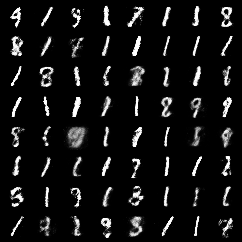

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 32 [0/60000 (0%)]	Discriminator Loss: 0.403390	Generator Loss: 2.827067
Train Epoch: 32 [12800/60000 (21%)]	Discriminator Loss: 0.496118	Generator Loss: 2.785039
Train Epoch: 32 [25600/60000 (43%)]	Discriminator Loss: 0.505643	Generator Loss: 2.827192
Train Epoch: 32 [38400/60000 (64%)]	Discriminator Loss: 0.412321	Generator Loss: 3.532494
Train Epoch: 32 [51200/60000 (85%)]	Discriminator Loss: 0.425154	Generator Loss: 3.502801
====> Epoch: 32 Average Train Generator loss: 2.9880
====> Epoch: 32 Average Train Discriminator loss: 0.4711


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


====> Epoch: 32 Average Test Generator loss: 2.9977
====> Epoch: 32 Average Test Discriminator loss: 0.5059
Sample of generated images


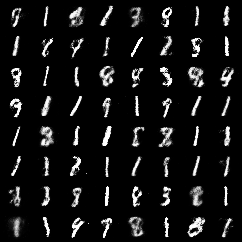



Train Epoch: 33 [0/60000 (0%)]	Discriminator Loss: 0.395947	Generator Loss: 3.371970


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 33 [12800/60000 (21%)]	Discriminator Loss: 0.431931	Generator Loss: 2.818339
Train Epoch: 33 [25600/60000 (43%)]	Discriminator Loss: 0.499401	Generator Loss: 3.187484
Train Epoch: 33 [38400/60000 (64%)]	Discriminator Loss: 0.449497	Generator Loss: 2.777936
Train Epoch: 33 [51200/60000 (85%)]	Discriminator Loss: 0.587492	Generator Loss: 2.666031
====> Epoch: 33 Average Train Generator loss: 2.9752
====> Epoch: 33 Average Train Discriminator loss: 0.4746


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


====> Epoch: 33 Average Test Generator loss: 3.1068
====> Epoch: 33 Average Test Discriminator loss: 0.4940
Sample of generated images


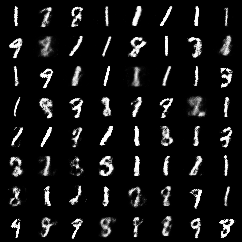

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 34 [0/60000 (0%)]	Discriminator Loss: 0.447729	Generator Loss: 3.250775
Train Epoch: 34 [12800/60000 (21%)]	Discriminator Loss: 0.473857	Generator Loss: 3.142868
Train Epoch: 34 [25600/60000 (43%)]	Discriminator Loss: 0.394934	Generator Loss: 3.427859
Train Epoch: 34 [38400/60000 (64%)]	Discriminator Loss: 0.479598	Generator Loss: 2.710278
Train Epoch: 34 [51200/60000 (85%)]	Discriminator Loss: 0.476109	Generator Loss: 2.612046
====> Epoch: 34 Average Train Generator loss: 2.9319
====> Epoch: 34 Average Train Discriminator loss: 0.4815


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


====> Epoch: 34 Average Test Generator loss: 2.7201
====> Epoch: 34 Average Test Discriminator loss: 0.5289
Sample of generated images


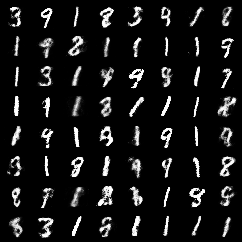



Train Epoch: 35 [0/60000 (0%)]	Discriminator Loss: 0.374396	Generator Loss: 3.191361


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 35 [12800/60000 (21%)]	Discriminator Loss: 0.401929	Generator Loss: 3.347980
Train Epoch: 35 [25600/60000 (43%)]	Discriminator Loss: 0.321108	Generator Loss: 3.310021
Train Epoch: 35 [38400/60000 (64%)]	Discriminator Loss: 0.594453	Generator Loss: 2.948003
Train Epoch: 35 [51200/60000 (85%)]	Discriminator Loss: 0.411838	Generator Loss: 2.658156
====> Epoch: 35 Average Train Generator loss: 2.8798
====> Epoch: 35 Average Train Discriminator loss: 0.4884


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


====> Epoch: 35 Average Test Generator loss: 2.8423
====> Epoch: 35 Average Test Discriminator loss: 0.6022
Sample of generated images


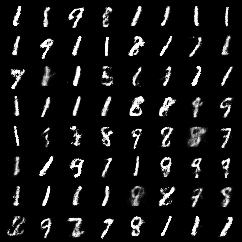

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 36 [0/60000 (0%)]	Discriminator Loss: 0.493020	Generator Loss: 2.897512
Train Epoch: 36 [12800/60000 (21%)]	Discriminator Loss: 0.474711	Generator Loss: 2.574050
Train Epoch: 36 [25600/60000 (43%)]	Discriminator Loss: 0.500144	Generator Loss: 2.851034
Train Epoch: 36 [38400/60000 (64%)]	Discriminator Loss: 0.576634	Generator Loss: 2.783553
Train Epoch: 36 [51200/60000 (85%)]	Discriminator Loss: 0.542551	Generator Loss: 2.934900
====> Epoch: 36 Average Train Generator loss: 2.8785
====> Epoch: 36 Average Train Discriminator loss: 0.4925


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


====> Epoch: 36 Average Test Generator loss: 2.8951
====> Epoch: 36 Average Test Discriminator loss: 0.4933
Sample of generated images


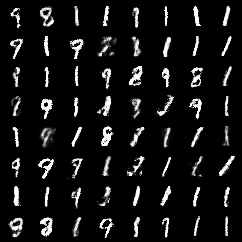



Train Epoch: 37 [0/60000 (0%)]	Discriminator Loss: 0.437136	Generator Loss: 3.183084


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 37 [12800/60000 (21%)]	Discriminator Loss: 0.569982	Generator Loss: 2.934812
Train Epoch: 37 [25600/60000 (43%)]	Discriminator Loss: 0.470793	Generator Loss: 2.991734
Train Epoch: 37 [38400/60000 (64%)]	Discriminator Loss: 0.416625	Generator Loss: 2.880032
Train Epoch: 37 [51200/60000 (85%)]	Discriminator Loss: 0.405760	Generator Loss: 2.701442
====> Epoch: 37 Average Train Generator loss: 2.8826
====> Epoch: 37 Average Train Discriminator loss: 0.5047


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


====> Epoch: 37 Average Test Generator loss: 2.4323
====> Epoch: 37 Average Test Discriminator loss: 0.6617
Sample of generated images


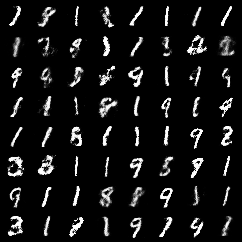



Train Epoch: 38 [0/60000 (0%)]	Discriminator Loss: 0.698951	Generator Loss: 2.536807


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 38 [12800/60000 (21%)]	Discriminator Loss: 0.686080	Generator Loss: 2.740002
Train Epoch: 38 [25600/60000 (43%)]	Discriminator Loss: 0.410201	Generator Loss: 2.725413
Train Epoch: 38 [38400/60000 (64%)]	Discriminator Loss: 0.416365	Generator Loss: 2.915919
Train Epoch: 38 [51200/60000 (85%)]	Discriminator Loss: 0.668720	Generator Loss: 2.523411
====> Epoch: 38 Average Train Generator loss: 2.8937
====> Epoch: 38 Average Train Discriminator loss: 0.5029


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


====> Epoch: 38 Average Test Generator loss: 2.5996
====> Epoch: 38 Average Test Discriminator loss: 0.5642
Sample of generated images


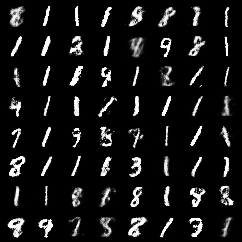

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 39 [0/60000 (0%)]	Discriminator Loss: 0.470560	Generator Loss: 2.882391
Train Epoch: 39 [12800/60000 (21%)]	Discriminator Loss: 0.494895	Generator Loss: 3.101787
Train Epoch: 39 [25600/60000 (43%)]	Discriminator Loss: 0.548050	Generator Loss: 2.906005
Train Epoch: 39 [38400/60000 (64%)]	Discriminator Loss: 0.619500	Generator Loss: 3.016443
Train Epoch: 39 [51200/60000 (85%)]	Discriminator Loss: 0.519119	Generator Loss: 2.867753
====> Epoch: 39 Average Train Generator loss: 2.8570
====> Epoch: 39 Average Train Discriminator loss: 0.5078


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


====> Epoch: 39 Average Test Generator loss: 2.5769
====> Epoch: 39 Average Test Discriminator loss: 0.5989
Sample of generated images


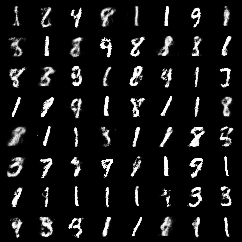



Train Epoch: 40 [0/60000 (0%)]	Discriminator Loss: 0.534256	Generator Loss: 2.846269


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 40 [12800/60000 (21%)]	Discriminator Loss: 0.508885	Generator Loss: 2.792500
Train Epoch: 40 [25600/60000 (43%)]	Discriminator Loss: 0.595477	Generator Loss: 2.343132
Train Epoch: 40 [38400/60000 (64%)]	Discriminator Loss: 0.663480	Generator Loss: 2.768674
Train Epoch: 40 [51200/60000 (85%)]	Discriminator Loss: 0.579357	Generator Loss: 2.711193
====> Epoch: 40 Average Train Generator loss: 2.7743
====> Epoch: 40 Average Train Discriminator loss: 0.5153


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


====> Epoch: 40 Average Test Generator loss: 2.5727
====> Epoch: 40 Average Test Discriminator loss: 0.5907
Sample of generated images


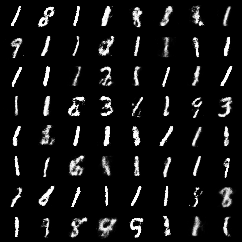

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 41 [0/60000 (0%)]	Discriminator Loss: 0.622109	Generator Loss: 2.549482
Train Epoch: 41 [12800/60000 (21%)]	Discriminator Loss: 0.559031	Generator Loss: 2.623535
Train Epoch: 41 [25600/60000 (43%)]	Discriminator Loss: 0.592419	Generator Loss: 2.748598
Train Epoch: 41 [38400/60000 (64%)]	Discriminator Loss: 0.525545	Generator Loss: 2.784512
Train Epoch: 41 [51200/60000 (85%)]	Discriminator Loss: 0.472655	Generator Loss: 2.608062
====> Epoch: 41 Average Train Generator loss: 2.7150
====> Epoch: 41 Average Train Discriminator loss: 0.5219


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


====> Epoch: 41 Average Test Generator loss: 2.4288
====> Epoch: 41 Average Test Discriminator loss: 0.5975
Sample of generated images


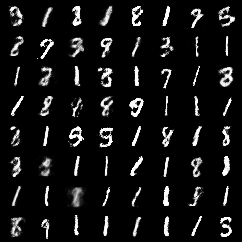



Train Epoch: 42 [0/60000 (0%)]	Discriminator Loss: 0.590700	Generator Loss: 2.504680


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 42 [12800/60000 (21%)]	Discriminator Loss: 0.441267	Generator Loss: 2.598320
Train Epoch: 42 [25600/60000 (43%)]	Discriminator Loss: 0.619032	Generator Loss: 2.733166
Train Epoch: 42 [38400/60000 (64%)]	Discriminator Loss: 0.583861	Generator Loss: 2.450891
Train Epoch: 42 [51200/60000 (85%)]	Discriminator Loss: 0.543140	Generator Loss: 2.583726
====> Epoch: 42 Average Train Generator loss: 2.7252
====> Epoch: 42 Average Train Discriminator loss: 0.5233


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


====> Epoch: 42 Average Test Generator loss: 2.9116
====> Epoch: 42 Average Test Discriminator loss: 0.6217
Sample of generated images


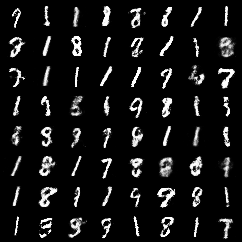

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 43 [0/60000 (0%)]	Discriminator Loss: 0.542216	Generator Loss: 3.073492
Train Epoch: 43 [12800/60000 (21%)]	Discriminator Loss: 0.557251	Generator Loss: 3.192567
Train Epoch: 43 [25600/60000 (43%)]	Discriminator Loss: 0.534870	Generator Loss: 3.244620
Train Epoch: 43 [38400/60000 (64%)]	Discriminator Loss: 0.506376	Generator Loss: 2.983266
Train Epoch: 43 [51200/60000 (85%)]	Discriminator Loss: 0.419112	Generator Loss: 2.826224
====> Epoch: 43 Average Train Generator loss: 2.7315
====> Epoch: 43 Average Train Discriminator loss: 0.5284


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


====> Epoch: 43 Average Test Generator loss: 2.7302
====> Epoch: 43 Average Test Discriminator loss: 0.5917
Sample of generated images


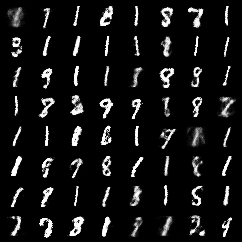



Train Epoch: 44 [0/60000 (0%)]	Discriminator Loss: 0.500561	Generator Loss: 2.523915


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 44 [12800/60000 (21%)]	Discriminator Loss: 0.463101	Generator Loss: 3.233273
Train Epoch: 44 [25600/60000 (43%)]	Discriminator Loss: 0.512709	Generator Loss: 2.772432
Train Epoch: 44 [38400/60000 (64%)]	Discriminator Loss: 0.557488	Generator Loss: 2.840328
Train Epoch: 44 [51200/60000 (85%)]	Discriminator Loss: 0.587133	Generator Loss: 2.600666
====> Epoch: 44 Average Train Generator loss: 2.7058
====> Epoch: 44 Average Train Discriminator loss: 0.5257


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


====> Epoch: 44 Average Test Generator loss: 2.4891
====> Epoch: 44 Average Test Discriminator loss: 0.6198
Sample of generated images


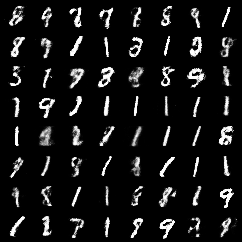

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 45 [0/60000 (0%)]	Discriminator Loss: 0.553119	Generator Loss: 2.471423
Train Epoch: 45 [12800/60000 (21%)]	Discriminator Loss: 0.432615	Generator Loss: 2.985217
Train Epoch: 45 [25600/60000 (43%)]	Discriminator Loss: 0.538160	Generator Loss: 2.530264
Train Epoch: 45 [38400/60000 (64%)]	Discriminator Loss: 0.531142	Generator Loss: 3.348920
Train Epoch: 45 [51200/60000 (85%)]	Discriminator Loss: 0.445698	Generator Loss: 3.047581
====> Epoch: 45 Average Train Generator loss: 2.6825
====> Epoch: 45 Average Train Discriminator loss: 0.5295


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


====> Epoch: 45 Average Test Generator loss: 2.6084
====> Epoch: 45 Average Test Discriminator loss: 0.6130
Sample of generated images


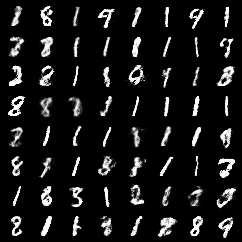

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 46 [0/60000 (0%)]	Discriminator Loss: 0.513693	Generator Loss: 2.643887
Train Epoch: 46 [12800/60000 (21%)]	Discriminator Loss: 0.513881	Generator Loss: 2.495502
Train Epoch: 46 [25600/60000 (43%)]	Discriminator Loss: 0.467332	Generator Loss: 3.215964
Train Epoch: 46 [38400/60000 (64%)]	Discriminator Loss: 0.324822	Generator Loss: 2.792837
Train Epoch: 46 [51200/60000 (85%)]	Discriminator Loss: 0.696280	Generator Loss: 2.708973
====> Epoch: 46 Average Train Generator loss: 2.7142
====> Epoch: 46 Average Train Discriminator loss: 0.5265


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


====> Epoch: 46 Average Test Generator loss: 2.1604
====> Epoch: 46 Average Test Discriminator loss: 0.6417
Sample of generated images


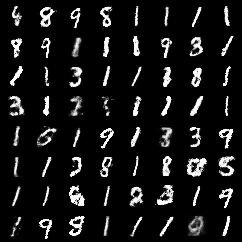



Train Epoch: 47 [0/60000 (0%)]	Discriminator Loss: 0.618728	Generator Loss: 2.489400


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 47 [12800/60000 (21%)]	Discriminator Loss: 0.613433	Generator Loss: 2.884574
Train Epoch: 47 [25600/60000 (43%)]	Discriminator Loss: 0.545037	Generator Loss: 2.381484
Train Epoch: 47 [38400/60000 (64%)]	Discriminator Loss: 0.465434	Generator Loss: 2.577961
Train Epoch: 47 [51200/60000 (85%)]	Discriminator Loss: 0.557535	Generator Loss: 2.748939
====> Epoch: 47 Average Train Generator loss: 2.6845
====> Epoch: 47 Average Train Discriminator loss: 0.5299


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


====> Epoch: 47 Average Test Generator loss: 2.7838
====> Epoch: 47 Average Test Discriminator loss: 0.5890
Sample of generated images


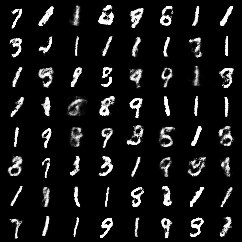

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 48 [0/60000 (0%)]	Discriminator Loss: 0.559860	Generator Loss: 2.699683
Train Epoch: 48 [12800/60000 (21%)]	Discriminator Loss: 0.411569	Generator Loss: 2.718818
Train Epoch: 48 [25600/60000 (43%)]	Discriminator Loss: 0.573593	Generator Loss: 2.596346
Train Epoch: 48 [38400/60000 (64%)]	Discriminator Loss: 0.554762	Generator Loss: 2.389980
Train Epoch: 48 [51200/60000 (85%)]	Discriminator Loss: 0.586496	Generator Loss: 2.536645
====> Epoch: 48 Average Train Generator loss: 2.6796
====> Epoch: 48 Average Train Discriminator loss: 0.5326


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


====> Epoch: 48 Average Test Generator loss: 2.4087
====> Epoch: 48 Average Test Discriminator loss: 0.5582
Sample of generated images


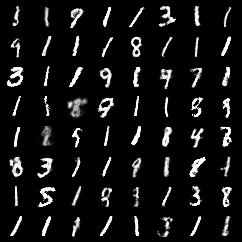



Train Epoch: 49 [0/60000 (0%)]	Discriminator Loss: 0.481789	Generator Loss: 2.207095


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 49 [12800/60000 (21%)]	Discriminator Loss: 0.555333	Generator Loss: 2.438338
Train Epoch: 49 [25600/60000 (43%)]	Discriminator Loss: 0.633591	Generator Loss: 2.524028
Train Epoch: 49 [38400/60000 (64%)]	Discriminator Loss: 0.585328	Generator Loss: 2.618856
Train Epoch: 49 [51200/60000 (85%)]	Discriminator Loss: 0.534917	Generator Loss: 2.843738
====> Epoch: 49 Average Train Generator loss: 2.6518
====> Epoch: 49 Average Train Discriminator loss: 0.5339


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


====> Epoch: 49 Average Test Generator loss: 2.6472
====> Epoch: 49 Average Test Discriminator loss: 0.6485
Sample of generated images


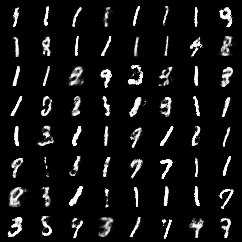

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Train Epoch: 50 [0/60000 (0%)]	Discriminator Loss: 0.620526	Generator Loss: 2.470474
Train Epoch: 50 [12800/60000 (21%)]	Discriminator Loss: 0.425435	Generator Loss: 2.851954
Train Epoch: 50 [25600/60000 (43%)]	Discriminator Loss: 0.596126	Generator Loss: 2.544338
Train Epoch: 50 [38400/60000 (64%)]	Discriminator Loss: 0.495384	Generator Loss: 2.530827
Train Epoch: 50 [51200/60000 (85%)]	Discriminator Loss: 0.584360	Generator Loss: 2.435334
====> Epoch: 50 Average Train Generator loss: 2.6687
====> Epoch: 50 Average Train Discriminator loss: 0.5322


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8770337ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


====> Epoch: 50 Average Test Generator loss: 2.9225
====> Epoch: 50 Average Test Discriminator loss: 0.6531
Sample of generated images


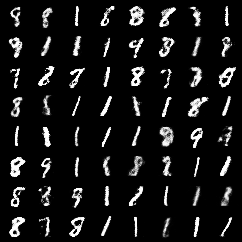

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


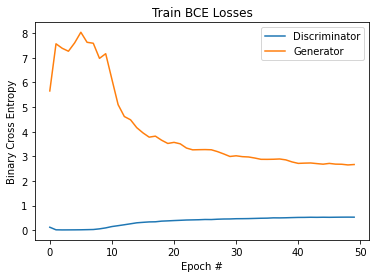

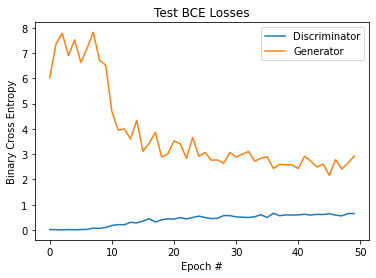

In [ ]:
# train and test gan
epochs = 50
discriminator_average_train_losses = []
discriminator_average_test_losses = []
generator_average_train_losses = []
generator_average_test_losses = []
generator_model = Generator().to(device)
generator_optimizer = optim.Adam(generator_model.parameters(), lr=1e-3)
discriminator_model = Discriminator().to(device)
discriminator_optimizer = optim.Adam(discriminator_model.parameters(), lr=1e-3)
for epoch in range(1, epochs + 1):
    generator_average_train_loss, discriminator_average_train_loss = gan_train(epoch, generator_model, generator_optimizer, discriminator_model, discriminator_optimizer)
    discriminator_average_train_losses.append(discriminator_average_train_loss)
    generator_average_train_losses.append(generator_average_train_loss)
    generator_average_test_loss, discriminator_average_test_loss = gan_test(epoch, generator_model, discriminator_model)
    discriminator_average_test_losses.append(discriminator_average_test_loss)
    generator_average_test_losses.append(generator_average_test_loss)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = generator_model(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')
        print('Sample of generated images')
        display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')

# Plot Train losses
plt.plot(discriminator_average_train_losses)
plt.plot(generator_average_train_losses)
plt.title('Train BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['Discriminator','Generator'], loc='upper right')
plt.show()

# Plot Test Losses
plt.plot(discriminator_average_test_losses)
plt.plot(generator_average_test_losses)
plt.title('Test BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['Discriminator','Generator'], loc='upper right')
plt.show()


Note that the both the training and test losses graph follow the same trend: Discriminator's entropy increases while generator's entropy decreases. This is because at the beginning, the generator does a really poor job of generating images from the dataset, (as shown in the first few iterations) and the discriminator can detect it rather easily. However, after several epochs, the generator starts to get better at generating fake images (as shown in the last few iterations) to a point where the discriminator fails to differentiate between the two sometimes. Notice that the generator is generating more images of the number 1. This is probably because number 1 is the easiest digit to fool the discriminator because it is probably the simplest digit from 0-9.

Note that GAN performs better than VAE here because GAN does not need to approximate the distribution given by the data, but instead it adapts to Game Theory and hence generates sharper images in order to fool the discriminator.